# Coedathon 1
**Nikki Aaron**

**Luke Moles (lmm8fb)**

**Annie Williams**

In [494]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

## Process Data

In [495]:
# from google.colab import files
# uploaded = files.upload()

In [496]:
# CHAS is categorical
# RAD might be categorical
housing = pd.read_table('housing.csv', header=None)
housing = pd.DataFrame(housing[0].str.split().to_list(),
                       columns=['CRIM','ZN','INDUS','CHAS','NOX',
                                'RM','AGE','DIS','RAD','TAX',
                                'PTRATIO','MEDV','B','LSTAT'])
housing = housing.astype('float64')
housing.CHAS = pd.Categorical(housing.CHAS)
housing.RAD = pd.Categorical(housing.RAD)
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [497]:
housing.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
MEDV        float64
B           float64
LSTAT       float64
dtype: object

Now we can assemble the features and labels into a TF dataset.

In [498]:
# separate features and labels
features = housing.copy()
medv = features.pop('MEDV')

In [499]:
# build dataset
dataset = tf.data.Dataset.from_tensor_slices((features.values, medv.values))

In [500]:
# check top entries
for i,j in dataset.take(3):
  print(f'Features: {i}\nTarget: {j}\n')

Features: [6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 4.980e+00 2.400e+01]
Target: 396.9

Features: [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
 7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 9.1400e+00
 2.1600e+01]
Target: 396.9

Features: [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
 6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 4.0300e+00
 3.4700e+01]
Target: 392.83



In [505]:
# split into train and test
# batch size 64
n_data = len(dataset)
n_train = int(0.9*n_data)
batch_size = 64

tf.random.set_seed(49)
dataset_shuff = dataset.shuffle(buffer_size=n_data, reshuffle_each_iteration=False)
train_data = dataset_shuff.take(n_train).batch(batch_size)
test_data = dataset_shuff.skip(n_train).batch(batch_size)

In [506]:
# verify shape
for feat, lab in test_data:
  print(lab)

tf.Tensor(
[396.21 396.9  396.9  376.57  96.73 395.5  393.49 394.33 391.25 392.18
 354.7  272.21 396.9  353.89 364.31  70.8  390.3  396.9  393.77 351.85
 396.9  393.36 388.37 390.49 394.74 395.63 394.43 396.9  394.08 396.9
 390.95 369.3  395.24 396.9  387.38 380.02 372.49 383.61 378.35 396.9
 347.88 393.23 394.51 285.83 389.15 395.21 395.56 350.65 391.93 396.9
 396.9 ], shape=(51,), dtype=float64)


## Build First Model

For the initial model we will use three hidden layers with an initial batch normalization layer. We use ReLU for all hidden activations.

In [507]:
keras.backend.clear_session()

inputs = keras.Input(shape=(13))
batch_norm = keras.layers.BatchNormalization()(inputs)
dense_1 = keras.layers.Dense(128, activation='relu')(batch_norm)
dense_2 = keras.layers.Dense(64, activation='relu')(dense_1)
dense_3 = keras.layers.Dense(32, activation='relu')(dense_2)
dense_4 = keras.layers.Dense(16, activation='relu')(dense_3)
outputs = keras.layers.Dense(1, activation='linear')(dense_4)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17    

For optimization, we use RMSprop to evaluate MSE loss. We can also report RMSE on the train and test sets to monitor performance during training.

In [508]:
model.compile(
    optimizer=tf.optimizers.RMSprop(),
    loss=tf.losses.MeanSquaredError(),
    metrics=tf.metrics.RootMeanSquaredError()
)

In [509]:
history = model.fit(train_data, epochs=300, validation_data=test_data)

Epoch 1/300
8/8 [==============================] - 1s 27ms/step - loss: 135942.6146 - root_mean_squared_error: 368.6996 - val_loss: 132748.9219 - val_root_mean_squared_error: 364.3473
Epoch 2/300
8/8 [==============================] - 0s 7ms/step - loss: 133968.6771 - root_mean_squared_error: 366.0117 - val_loss: 120096.2422 - val_root_mean_squared_error: 346.5490
Epoch 3/300
8/8 [==============================] - 0s 7ms/step - loss: 129514.2847 - root_mean_squared_error: 359.8719 - val_loss: 102967.1562 - val_root_mean_squared_error: 320.8849
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 121221.3524 - root_mean_squared_error: 348.1529 - val_loss: 83101.8906 - val_root_mean_squared_error: 288.2740
Epoch 5/300
8/8 [==============================] - 0s 7ms/step - loss: 108160.3906 - root_mean_squared_error: 328.8494 - val_loss: 62199.2695 - val_root_mean_squared_error: 249.3978
Epoch 6/300
8/8 [==============================] - 0s 8ms/step - loss: 90441.8411 - ro

## Results of the First Model

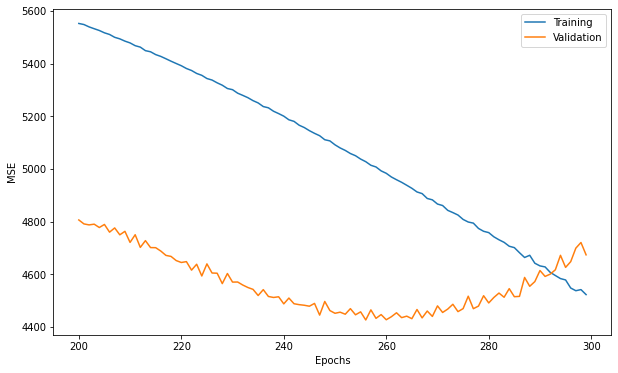

In [513]:
# plot the last 100 epochs for better picture of results
x = history.epoch[-100:]
y_train = history.history['loss'][-100:]
y_test = history.history['val_loss'][-100:]

fig = plt.figure(figsize=(10,6))
plt.plot(x, y_train, label='Training')
plt.plot(x, y_test, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend();

In [511]:
# evaluate at current epoch
model.evaluate(test_data)

1/1 [==============================] - 0s 16ms/step - loss: 4674.5981 - root_mean_squared_error: 68.3710


[4674.59814453125, 68.37103271484375]

In [512]:
# look at all of the predictions

preds = model.predict(test_data).squeeze()

actual = []
for feat,lab in test_data:
  actual.append(lab)
actual = np.array(actual)[0]

results = pd.DataFrame({'Actual':actual,
                        'Predicted':preds,
                        'Error':(preds-actual)})
results

,Actual,Predicted,Error
0,396.21,421.834869,25.624869
1,396.90,234.036026,-162.863974
2,396.90,324.563660,-72.336340
3,376.57,377.710999,1.140999
4,96.73,179.765671,83.035671
5,395.50,402.407349,6.907349
6,393.49,409.161591,15.671591
7,394.33,388.322998,-6.007002
8,391.25,356.990662,-34.259338
9,392.18,399.258209,7.078209


The results show that the model performs very well for most inputs, but it struggles to predict the median values where the targets are far below average.

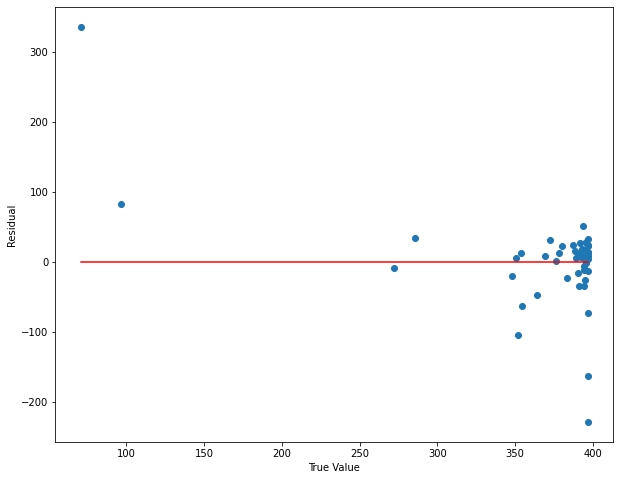

In [515]:
# residual plot

fig = plt.figure(figsize=(10,8))

plt.scatter(results.Actual, results.Error)
plt.plot(
    [results.Actual.min(),results.Actual.max()],
    [0,0],
    color='red'
)
plt.xlabel('True Value')
plt.ylabel('Residual');

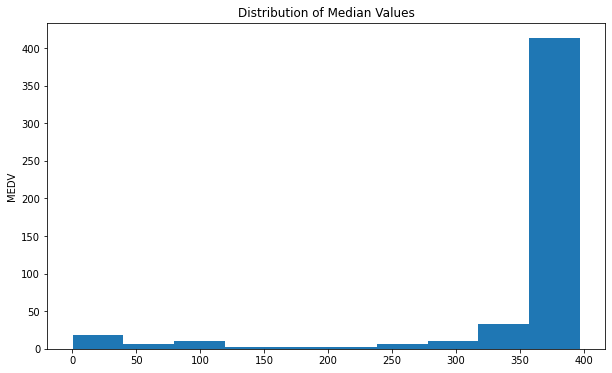

In [518]:
# distribution of MEDV

fig = plt.figure(figsize=(10,6))

plt.hist(medv)
plt.ylabel('MEDV')
plt.title('Distribution of Median Values');

The residual plot shows how our current model fails, and the histogram of target values illustrates a possible cause that we can investigate.

## Clustering

We can now try to use clustering to group regions that may be similar. There are many ways to do this, but the most success was found with k-means clustering of MEDV with 2 clusters.

In [528]:
# run through various values of K
kmax = 9
results = np.vstack((list(range(1, kmax)), np.zeros(kmax-1)))
for k in range(1, kmax):
  clust = KMeans(n_clusters=k)
  clust.fit(housing.MEDV.values.reshape(-1,1))
  wss = 0
  for i,item in enumerate(housing.MEDV.values):
    wss += np.linalg.norm(item - clust.cluster_centers_[clust.labels_[i]])
  results[1, k-1] = wss

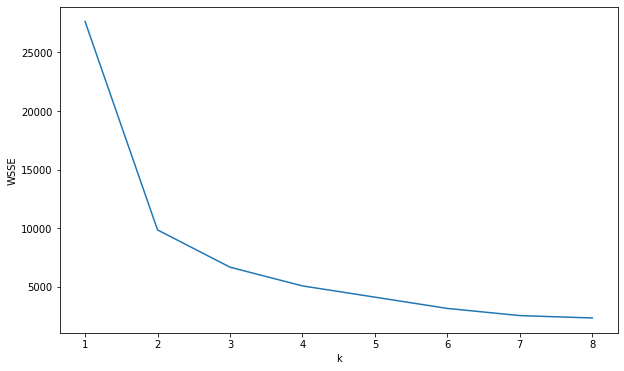

In [530]:
# Plot results of clustering
fig = plt.figure(figsize=(10,6))
plt.plot(results[0], results[1])
plt.xlabel('k')
plt.ylabel('WSSE');

In [534]:
# We proceed with KMeans on MEDV, k=2
clusters = KMeans(n_clusters=2)
clusters.fit(housing.MEDV.values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

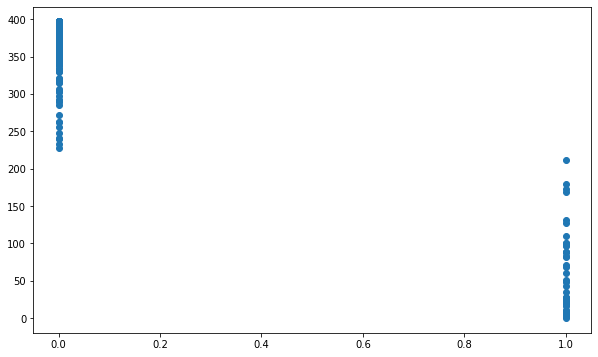

In [535]:
# Visualize clusters

dfkm = pd.DataFrame({'medv':housing.MEDV,
                     'cluster':clusters.labels_})

fig = plt.figure(figsize=(10,6))

plt.scatter(dfkm.cluster, dfkm.medv);

## Build Second Model

We now build the second model using the same architecture, but with cluster assingments added as a feature.

In [536]:
# add cluster label to features
features = housing.copy()
features['CLUSTER'] = clusters.labels_

# separate features and targets
medv = features.pop('MEDV')

In [537]:
# build dataset
dataset = tf.data.Dataset.from_tensor_slices((features.values, medv.values))

In [538]:
# split data and batch
n_data = len(dataset)
n_train = int(0.9*n_data)
batch_size = 64

tf.random.set_seed(49)
dataset_shuff = dataset.shuffle(buffer_size=n_data, reshuffle_each_iteration=False)
train_data = dataset_shuff.take(n_train).batch(batch_size)
test_data = dataset_shuff.skip(n_train).batch(batch_size)

In [548]:
# Build model with same architecture
# The only change is an input shape of 14 instead of 13
keras.backend.clear_session()

inputs = keras.Input(shape=(14))
batch_norm = keras.layers.BatchNormalization()(inputs)
dense_1 = keras.layers.Dense(128, activation='relu')(batch_norm)
dense_2 = keras.layers.Dense(64, activation='relu')(dense_1)
dense_3 = keras.layers.Dense(32, activation='relu')(dense_2)
outputs = keras.layers.Dense(1, activation='linear')(dense_3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14)                56        
_________________________________________________________________
dense (Dense)                (None, 128)               1920      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,345
Trainable params: 12,317
Non-trainable params: 28
________________________________________________________

In [549]:
# compile with RMSprop optimizer
model.compile(
    optimizer=tf.optimizers.RMSprop(),
    loss=tf.losses.MeanSquaredError(),
    metrics=tf.metrics.RootMeanSquaredError()
)

In [550]:
# trial runs of training show that proper fit occurs around 200 epochs
# so we implement "manual early stopping"
history = model.fit(train_data, epochs=200, validation_data=test_data)

Epoch 1/200
8/8 [==============================] - 1s 25ms/step - loss: 135846.1510 - root_mean_squared_error: 368.5683 - val_loss: 128237.7656 - val_root_mean_squared_error: 358.1030
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 133310.4774 - root_mean_squared_error: 365.1112 - val_loss: 117959.7656 - val_root_mean_squared_error: 343.4527
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 129159.3698 - root_mean_squared_error: 359.3795 - val_loss: 105863.1953 - val_root_mean_squared_error: 325.3662
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 122536.4418 - root_mean_squared_error: 350.0400 - val_loss: 92222.0703 - val_root_mean_squared_error: 303.6809
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 112846.6128 - root_mean_squared_error: 335.9079 - val_loss: 77966.0469 - val_root_mean_squared_error: 279.2240
Epoch 6/200
8/8 [==============================] - 0s 8ms/step - loss: 100156.8273 - r

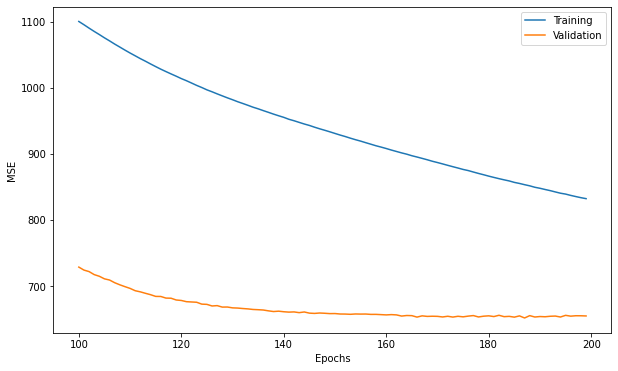

In [551]:
# plot the last 100 epochs for better picture of results
x = history.epoch[-100:]
y_train = history.history['loss'][-100:]
y_test = history.history['val_loss'][-100:]

fig = plt.figure(figsize=(10,6))
plt.plot(x, y_train, label='Training')
plt.plot(x, y_test, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend();

In [552]:
# evaluate RMSE on test set
model.evaluate(test_data)

1/1 [==============================] - 0s 18ms/step - loss: 654.7899 - root_mean_squared_error: 25.5889


[654.7899169921875, 25.588863372802734]

In [554]:
# show all predictions

preds = model.predict(test_data).squeeze()

actual = []
for feat,lab in test_data:
  actual.append(lab)
actual = np.array(actual)[0]

results = pd.DataFrame({'Actual':actual,
                        'Predicted':preds,
                        'Error':(preds-actual)})
results

,Actual,Predicted,Error
0,396.21,383.116943,-13.093057
1,396.90,374.451172,-22.448828
2,396.90,359.388458,-37.511542
3,376.57,364.862946,-11.707054
4,96.73,48.058842,-48.671158
5,395.50,394.028320,-1.471680
6,393.49,387.621857,-5.868143
7,394.33,368.896515,-25.433485
8,391.25,366.362244,-24.887756
9,392.18,391.356873,-0.823127


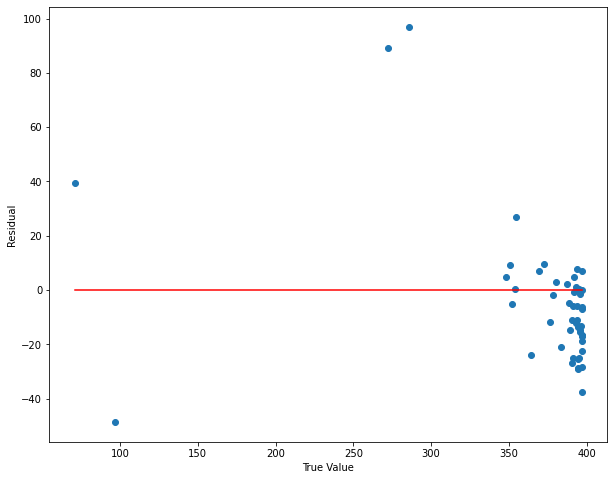

In [555]:
fig = plt.figure(figsize=(10,8))

plt.scatter(results.Actual, results.Error)
plt.plot(
    [results.Actual.min(),results.Actual.max()],
    [0,0],
    color='red'
)
plt.xlabel('True Value')
plt.ylabel('Residual');

Although it is far from perfect, we have greatly reduced RMSE by improving performance when predicting smaller MEDV. The final performance on the test set is:

RMSE = $25.5889$